In [ ]:
from importlib import  reload
import sys
from imp import  reload
import warnings
warnings.filterwarnings('ignore')
if sys.version[0] == '2':
  reload(sys)
  sys.setdefaultencoding("utf-8")

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
  
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
  
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Concatenate, Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Flatten
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution1D
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
import pandas as pd

df = pd.read_csv('clickbait_prepro_v1.csv')

df.head()

,headline,clickbait
0,بحث حوالي نصف المهاجرين بالمغرب يتوفرون على عمل,1
1,المكتب الوطني للسكك الحديدية يطلق برنامجا غنيا...,1
2,نقل المغني أركيلي إلى سجن في بروكلين تمهيدا لم...,1
3,ويفا يلغي أفضلية الهدف خارج القواعد بعد عاما,1
4,فلسطين تفوز على جزر القمر وتلتحق بمجموعة المغر...,1


In [ ]:
MAX_FEATURES = 6000
EMBED_SIZE = 128
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(df['headline'])
list_tokenized_data = tokenizer.texts_to_sequences(df['headline'])
RNN_CELL_SIZE = 3
  
MAX_LEN = 130  # Since our mean length is 128.5
X = pad_sequences(list_tokenized_data, maxlen=MAX_LEN)
y = df['clickbait']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(6421, 130) (6421,)
(1606, 130) (1606,)


###Step 2: Creating the Attention Layer

In [ ]:
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

### Step 3: The Embedding Layer

In [ ]:
sequence_input = Input(shape=(MAX_LEN,), dtype="int32")
embedded_sequences = Embedding(MAX_FEATURES, EMBED_SIZE)(sequence_input)

In [ ]:
embedded_sequences.shape

TensorShape([None, 130, 128])

### Step 4: Our Bi-directional RNN

In [ ]:
lstm = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences = True), name="bi_lstm_0")(embedded_sequences)

(lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences=True, return_state=True), name="bi_lstm_1")(lstm)

In [ ]:
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
context_vector, attention_weights = Attention(3)(lstm, state_h)
dense1 = Dense(3, activation="relu")(context_vector)
dropout = Dropout(0.1)(dense1)
output = Dense(1, activation="sigmoid")(dropout)
  
model = keras.Model(inputs=sequence_input, outputs=output)

In [ ]:
# summarize layers
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 130)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 130, 128)     768000      ['input_1[0][0]']                
                                                                                                  
 bi_lstm_0 (Bidirectional)      (None, 130, 6)       3168        ['embedding[0][0]']              
                                                                                                  
 bi_lstm_1 (Bidirectional)      [(None, 130, 6),     240         ['bi_lstm_0[0][0]']              
                                 (None, 3),                                                   

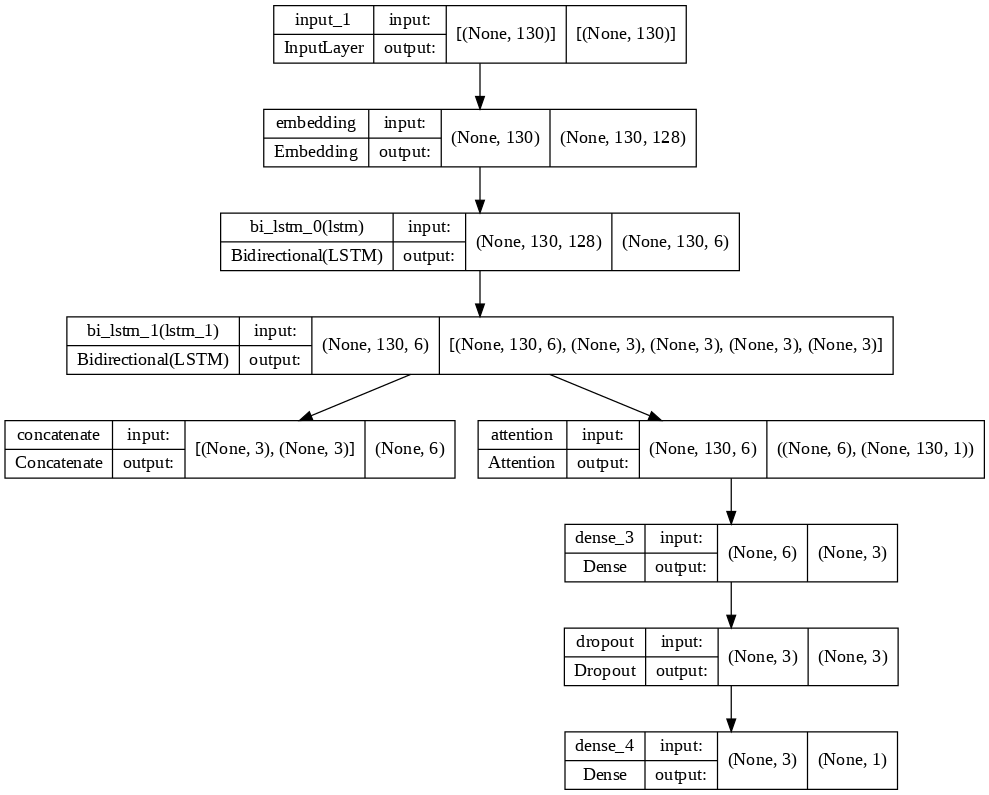

In [ ]:
keras.utils.plot_model(model, show_shapes=True, dpi=90)


### Step 5: Compiling the Model

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics='accuracy')

### Step 6: Training the Model

In [ ]:
BATCH_SIZE = 64
EPOCHS = 5
history = model.fit(X_train,Y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.2)

Epoch 1/5
81/81 [==============================] - 24s 197ms/step - loss: 0.6885 - accuracy: 0.5477 - val_loss: 0.6949 - val_accuracy: 0.5160
Epoch 2/5
81/81 [==============================] - 14s 175ms/step - loss: 0.6855 - accuracy: 0.5530 - val_loss: 0.6874 - val_accuracy: 0.5160
Epoch 3/5
81/81 [==============================] - 14s 175ms/step - loss: 0.5370 - accuracy: 0.8359 - val_loss: 0.3928 - val_accuracy: 0.9245
Epoch 4/5
81/81 [==============================] - 14s 176ms/step - loss: 0.2930 - accuracy: 0.9165 - val_loss: 0.3102 - val_accuracy: 0.9082
Epoch 5/5
81/81 [==============================] - 17s 210ms/step - loss: 0.1923 - accuracy: 0.9352 - val_loss: 0.2844 - val_accuracy: 0.9160


### Step 7: Evaluating the Model

In [ ]:
X_train.shape
X_test.shape

(1606, 130)

In [ ]:
score, accuracy = model.evaluate(X_test,Y_test)
print("score: %.2f" % (score))
print("accuracy; %.2f" % (accuracy))

51/51 [==============================] - 2s 31ms/step - loss: 0.2934 - accuracy: 0.9134
score: 0.29
accuracy; 0.91


<function matplotlib.pyplot.show>

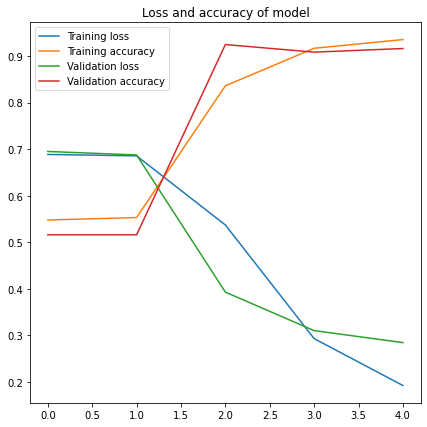

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,7))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title("Loss and accuracy of model")
plt.legend()
plt.show

In [ ]:
model.save_weights('model_attention.h5')